### Notebook for initializing polymer systems using a DPD potential

In [1]:
import matplotlib
import numpy as np  
import scipy.stats
import gsd, gsd.hoomd 
import freud 
import math
import itertools 
import hoomd 
import fresnel 
%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
def render(frame): 
    '''
    Visualize a simulation box within a jupyter notebook.
    
    '''
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5)
    geometry.position[:] = frame.particles.position
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, frame.configuration.box,box_radius=0.01)
    L = frame.configuration.box[0]
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

    if frame.bonds.N>0:
        geometry.radius[:] = [0.2]*frame.particles.N 

        all_bonds = np.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
        )
        bond_distances = np.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)
        L = frame.configuration.box[0]
        bond_indices = np.where(bond_distances < L/2)[0]
        filtered_bonds = all_bonds[bond_indices, :, :]
        
        bonds = fresnel.geometry.Cylinder(scene, N=len(filtered_bonds))
        bonds.material = fresnel.material.Material(roughness=0.5)
        bonds.outline_width = 0.05

        bonds.points[:] = filtered_bonds
        bonds.radius[:] = [0.1]*len(filtered_bonds)
        bonds.material.primitive_color_mix = 1.0
        bonds.color[:] = fresnel.color.linear([0.8, 0.8, 0.8])
                
    return fresnel.preview(scene)

In [3]:
def initialize_snapshot(num_pol, num_mon, density=0.85):
    '''
    Create a HOOMD snapshot of a cubic box with the number density given by input parameters.

    '''
    N = num_pol * num_mon
    L = np.cbrt(N / density)  # Calculate box size based on density
    positions = np.random.uniform(low=-L/2, high=L/2, size=(N, 3))
    bonds = []
    for i in range(num_pol):
        start = i * num_mon
        for j in range(num_mon - 1):
            bonds.append([start + j, start + j + 1])
    bonds = np.array(bonds)
    frame = gsd.hoomd.Frame()
    frame.particles.types = ['A']
    frame.particles.N = N
    frame.particles.position = positions
    frame.bonds.N = len(bonds)
    frame.bonds.group = bonds
    frame.bonds.types = ['b']
    frame.configuration.box = [L, L, L, 0, 0, 0]
    return frame

In [4]:
def pbc(d,box):
    for i in range(3):
        a = d[:,i]
        a[a < -box[i]/2] += box[i]
        a[a >  box[i]/2] -= box[i]
    return d

In [5]:
def check_bond_length_equillibration(gsdfile,bond_length,num_mon,num_pol):
    fene_bond_l = bond_length
    traj = gsd.hoomd.open(gsdfile)
    last_frame = traj[-1]
    frame_ds = []
    for j in range(num_pol):
        idx = j*num_mon
        d1 = last_frame.particles.position[idx:idx+num_mon-1] - last_frame.particles.position[idx+1:idx+num_mon]
        bond_l = np.linalg.norm(pbc(d1,frame.configuration.box),axis=1)
        frame_ds.append(bond_l)
    max_frame_bond_l = np.max(np.array(frame_ds))
    print("max bond length: ",max_frame_bond_l)
    if max_frame_bond_l <= fene_bond_l:
        print("DPD Simulation Finished.")
        return True
    if max_frame_bond_l > fene_bond_l:
        return False

## Parameters

In [12]:
num_pol = 50
num_mon = 50
kT = 1.5
cut = 2.5
l = 1.0 #bond length r_0
timestep = 0.01
gamma = 0.05 #DPD parameter
A = 100.0 #DPD parameter

## HOOMD simulation code

In [13]:
frame = initialize_snapshot(num_pol, num_mon, density=0.85)

#assign harmonic bond potentials
harmonic = hoomd.md.bond.Harmonic()
harmonic.params["b"] = dict(r0=l, k=100)

integrator = hoomd.md.Integrator(dt=timestep)
integrator.forces.append(harmonic)

#initialize HOOMD simulation object
simulation = hoomd.Simulation(device=hoomd.device.auto_select(),seed=12)
simulation.operations.integrator = integrator 
simulation.create_state_from_snapshot(frame) #create initial state of Simulation

#add ensemble method to Simulation
const_vol = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
integrator.methods.append(const_vol)

#define the neighbor list
nlist = hoomd.md.nlist.Cell(buffer=0.4)
simulation.operations.nlist = nlist

#define the forcefield
DPD = hoomd.md.pair.DPD(nlist, default_r_cut=cut, kT=kT)
DPD.params[('A', 'A')] = dict(A=A, gamma=gamma)
integrator.forces.append(DPD)
simulation.operations.integrator = integrator

#define write frequency for trajectory file
gsd_out = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(10), 
    mode='wb',
    dynamic=['property','momentum'],
    filename='run_len_%s_pol_%s.gsd'%(num_mon,num_pol),
    truncate=False)
simulation.operations.writers.append(gsd_out)

## Run code

In [14]:
#run the simulation! and log by flushing the writers
simulation.run(1_000)
gsd_out.flush()

fene_bond_l = 1.2
file = 'run_len_%s_pol_%s.gsd'%(num_mon,num_pol)
count = 1000


while not check_bond_length_equillibration(file,fene_bond_l,num_mon,num_pol):
    simulation.run(200)
    gsd_out.flush()
    count += 200
render(simulation.state.get_snapshot())
print(f"Finished in {count} iterations.")

max bond length:  7.7368255
max bond length:  7.129063
max bond length:  6.9165525
max bond length:  6.0392838
max bond length:  6.134603
max bond length:  6.219566
max bond length:  4.8812056
max bond length:  4.738427
max bond length:  4.2772803
max bond length:  4.179589
max bond length:  3.9816833
max bond length:  3.7217615
max bond length:  3.250731
max bond length:  3.2823389
max bond length:  3.2158341
max bond length:  2.9704134
max bond length:  2.58212
max bond length:  2.355928
max bond length:  2.4635084
max bond length:  2.363902
max bond length:  2.1660328
max bond length:  2.152586
max bond length:  1.9468492
max bond length:  1.795271
max bond length:  1.6700395
max bond length:  1.9587967
max bond length:  1.8289056
max bond length:  1.6291702
max bond length:  1.5501505
max bond length:  1.4759638
max bond length:  1.405448
max bond length:  1.2915223
max bond length:  1.3629794
max bond length:  1.2945685
max bond length:  1.2355489
max bond length:  1.1747719
DPD S

### Graph the bond length relaxation

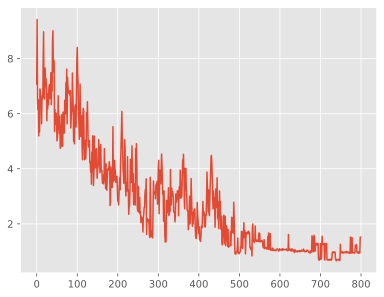

In [15]:
import matplotlib.pyplot as plt

with gsd.hoomd.open('run_len_%s_pol_%s.gsd'%(num_mon,num_pol),'r') as traj:
    avg_frame_bond_l = []
    for frame in traj:
        bond_l = []
        for i in range(0,num_mon-2):
            dr = np.linalg.norm((frame.particles.position[i+1] - frame.particles.position[i]), axis=0)
            bond_l.append(dr)
        avg_frame_bond_l.append(np.mean(bond_l))

plt.plot(avg_frame_bond_l)